In [2]:
import sionna
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Layer

In [3]:
sionna.seed = 42

In [4]:
#gradinet communication to n-n system 
binary_source = sionna.utils.BinarySource()
num_bits_per_symbol = 6
constellation = sionna.mapping.Constellation('qam', num_bits_per_symbol=num_bits_per_symbol, trainable=True)
mapper = sionna.mapping.Mapper(constellation=constellation)
demapper = sionna.mapping.Demapper('app', constellation=constellation)
awgn_ch = sionna.channel.AWGN()

### EBNO_DB ANTE KYAAA JII
### **What Does the \(E_b/N_0\) Parameter in 5G Express?**  

\(E_b/N_0\) (Energy per Bit to Noise Power Spectral Density Ratio) is a fundamental parameter in wireless communication, including **5G**, that expresses the **signal quality** in relation to noise. It is widely used to analyze the performance of modulation and coding schemes.

---

## **1️⃣ Definition of \(E_b/N_0\)**
\[
E_b/N_0 = \frac{S}{N_0 \cdot R_b}
\]
where:
- \(E_b\) = **Energy per transmitted bit** (Joules per bit)
- \(N_0\) = **Noise Power Spectral Density** (Watts per Hz)
- \(S\) = **Received signal power** (Watts)
- \(R_b\) = **Bit rate (bps)**, which depends on modulation and coding

---

## **2️⃣ Why is \(E_b/N_0\) Important in 5G?**
### **(a) Link Budget Analysis**
- Determines **required power levels** to achieve a specific **Bit Error Rate (BER)**.
- Helps in estimating **coverage and capacity** for different 5G deployments.

### **(b) Modulation & Coding Selection**
- 5G **Adapts Modulation & Coding Schemes (MCS)** dynamically based on \(E_b/N_0\).
- **Higher \(E_b/N_0\) → Higher-order modulation (e.g., 256-QAM)** for better throughput.
- **Lower \(E_b/N_0\) → Lower-order modulation (e.g., QPSK, BPSK)** for better reliability.

### **(c) Network Optimization**
- Used for **power control, scheduling, and beamforming** in **Massive MIMO** and beam-based transmissions.
- Helps in **handover decisions** by ensuring that the next base station provides sufficient \(E_b/N_0\).

---

## **3️⃣ Relation to Other Parameters**
### **(a) \(E_b/N_0\) vs. \(E_s/N_0\)**
- \(E_s/N_0\) (Symbol Energy to Noise Ratio) is used for modulation schemes:
  \[
  E_s/N_0 = E_b/N_0 \cdot \log_2(M)
  \]
  where **\(M\)** is the modulation order (e.g., 16-QAM, 64-QAM).

### **(b) \(E_b/N_0\) vs. SNR**
- \(E_b/N_0\) is related to the **Signal-to-Noise Ratio (SNR)** as:
  \[
  SNR = \frac{E_b}{N_0} \cdot R_b / B
  \]
  where **\(B\)** is the bandwidth.
- **For the same SNR, lower coding rates require higher \(E_b/N_0\)**.

---

## **4️⃣ Practical Use in 5G Simulations**
- **Used in tools like Sionna** to model link performance and **simulate BER vs. \(E_b/N_0\)**.
- Helps in designing **LDPC decoders**, **beamforming algorithms**, and **adaptive modulation**.

---

### **🔑 Key Takeaways**
✅ \(E_b/N_0\) measures signal strength relative to noise **on a per-bit basis**.  
✅ It helps in **modulation and coding adaptation**, **beamforming**, and **power control**.  
✅ Used in **5G link bWould you like to simulate \(E_b/N_0\) effects using Sionna? 🚀

In [5]:
#simulating the forward pass
batch_size = 128
ebno_db = 17
no = sionna.utils.ebnodb2no(ebno_db=ebno_db, num_bits_per_symbol=num_bits_per_symbol, coderate=1)
bits = binary_source([batch_size, 1200])
x = mapper(bits)
y = awgn_ch([x, no])
llr = demapper([y, no])

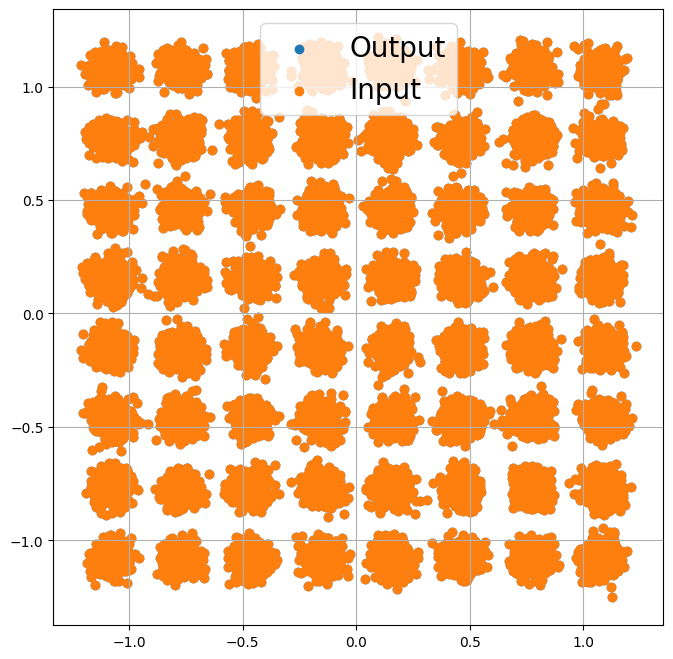

In [6]:
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1.0)
plt.grid(True)
plt.scatter(tf.math.real(y),tf.math.imag(y), label='Output')
plt.scatter(tf.math.real(y),tf.math.imag(y), label='Input')
plt.legend(fontsize=20);

In [7]:
## now SGD with a loss function is imposed 
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
print(f'BCE: {bce(bits, llr)}')

BCE: 0.00011843557877000421


### step 1 - perform a forward pass
### step 2 - compuet the loss function 
### step 3 - apply the gradients to the wts 

In [8]:
### step1
# need to enable the forwrd pass
with tf.GradientTape() as tape:
    bits = binary_source([batch_size, 1200])
    x = mapper(bits)
    y = awgn_ch([x, no])
    llr = demapper([y, no])
    loss = bce(bits, llr)  


In [9]:
# coputing the loss function step 2
gradient = tape.gradient(loss, tape.watched_variables())

In [10]:
# combining the conventional and non-trainalbe algo, for signalprocessing
for g in gradient:
    print(g.shape)

(2, 64)


In [11]:
#step 3
optimizer = tf.keras.optimizers.Adam(1e-2)

In [12]:
#traianble wts 
optimizer.apply_gradients(zip(gradient, tape.watched_variables()))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

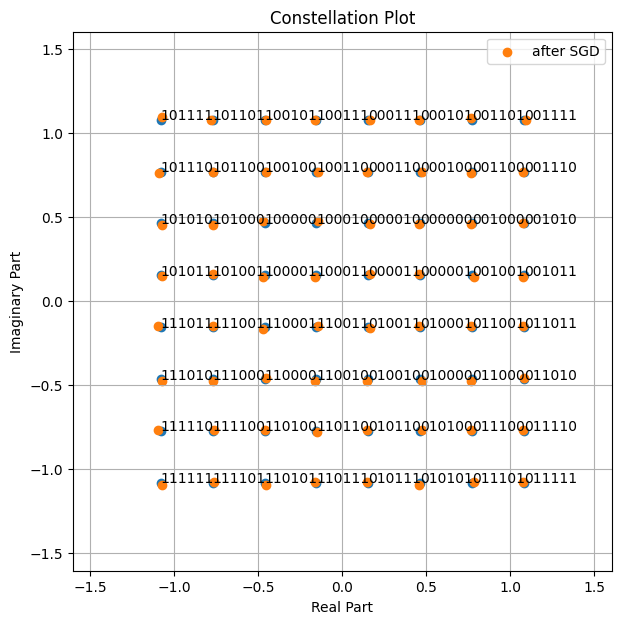

In [14]:
fig = sionna.mapping.Constellation('qam', num_bits_per_symbol).show()
fig.axes[0].scatter(tf.math.real(constellation.points), tf.math.imag(constellation.points), label="after SGD")
fig.axes[0].legend()

### creating custom layers 

In [27]:
## mapper demapper, using keras 
class NeuralDemapper(Layer):
    def __init__(self):
        super().__init__()
        self.dense_1 = Dense(64, 'relu')
        self.dense_2 = Dense(64, 'relu')
        self.dense_3 = Dense(num_bits_per_symbol, None)
    def call(self, y):
        nn_input = tf.stack([tf.math.real(y), tf.math.imag(y)], axis=-1)
        z = self.dense_1(nn_input)
        z = self.dense_2(z)
        z = self.dense_3(z)
        llr = tf.reshape(z, [tf.shape(y)[0], -1])
        return llr

In [28]:
class End2EndSystem(Model): #inherits from keras model
    def __init__(self, training):
        super().__init__()  # call the keras model
        self.constellation = sionna.mapping.Constellation('qam', num_bits_per_symbol, trainable=True)
        self.mapper = sionna.mapping.Mapper(constellation=self.constellation)
        self.demapper = NeuralDemapper() # intantiate the nn class
        self.binary_source = sionna.utils.BinarySource()
        self.awgn_channel = sionna.channel.AWGN()
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.training = training 

    @tf.function(jit_compile=True) #graph exe for speed
    def __call__(self, batch_size, ebno_db):
        #no channel coding used we set coderate=1
        no = sionna.utils.ebnodb2no(ebno_db, num_bits_per_symbol=num_bits_per_symbol,
                                    coderate=1.0)
        bits = self.binary_source([batch_size, 1200]) #blacklength set 1200
        x = self.mapper(bits)
        y = self.awgn_channel([x, no])
        llr = self.demapper(y)
        if self.training:
            loss = self.bce(bits, llr)
            return loss
        else:
            return bits, llr
                                    
        
        

### since the above initiated NN posses some random wts performance migh be poor

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     10.0 | 2.6647e-02 | 1.0000e+00 |        4093 |      153600 |          128 |         128 |         0.7 |reached target bit errors
   10.526 | 2.1458e-02 | 1.0000e+00 |        3296 |      153600 |          128 |         128 |         0.1 |reached target bit errors
   11.053 | 1.6185e-02 | 1.0000e+00 |        2486 |      153600 |          128 |         128 |         0.1 |reached target bit errors
   11.579 | 1.2253e-02 | 1.0000e+00 |        1882 |      153600 |          128 |         128 |         0.1 |reached target bit errors
   12.105 | 9.4661e-03 | 1.0000e+00 |        1454 |      153600 |          128 |         128 |         0.1 |reached target bit errors
   12.632 | 6.5299e-03 | 1.0000e+00 |        1003 |      153600 |          

(<tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([0.46720703, 0.46630208, 0.46787109, 0.46615234, 0.4660026 ,
        0.46724609, 0.46721354, 0.46682292, 0.46711589, 0.4680599 ,
        0.46806641, 0.46516927, 0.46460286, 0.46552083, 0.4638151 ,
        0.46602214, 0.46715495, 0.46627604, 0.46419922, 0.46491536])>,
 <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.])>)

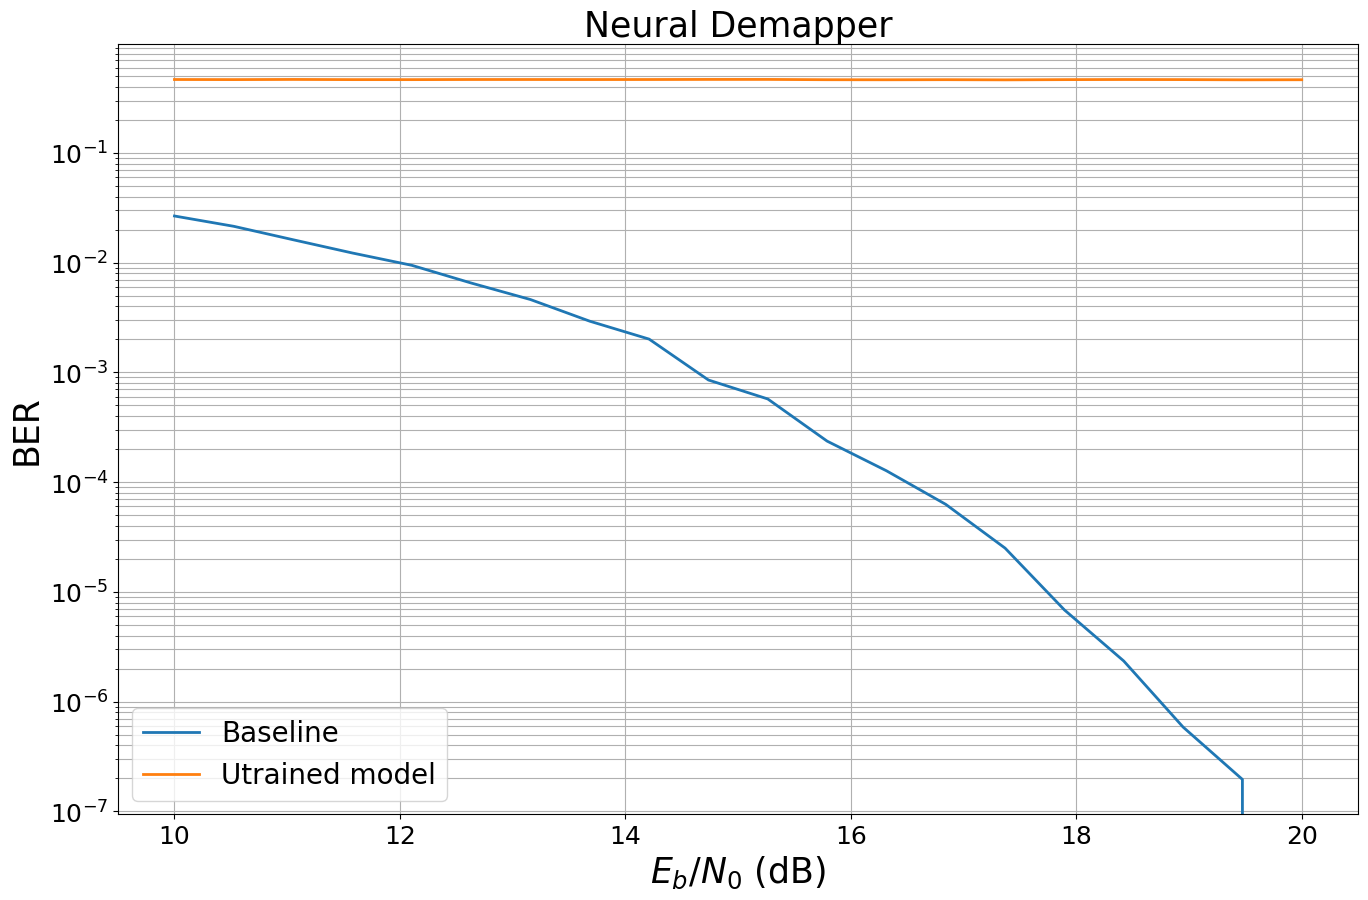

In [29]:
ebno_db_min = 10.0
ebn0_db_max = 20.0
#basel line
class Baseline(Model): # inherits from keras
    def __init__(self):
        super().__init__() #shd call keras model initialozer
        self.constellation = sionna.mapping.Constellation('qam', num_bits_per_symbol)
        self.mapper = sionna.mapping.Mapper(constellation=self.constellation)
        self.demapper = sionna.mapping.Demapper('app', constellation=self.constellation)
        self.binary_source = sionna.utils.BinarySource()
        self.awgn_channel = sionna.channel.AWGN()

    @tf.function 
    def __call__(self, batch_size, ebno_db):
        no = sionna.utils.ebnodb2no(ebno_db, num_bits_per_symbol=num_bits_per_symbol, coderate=1.0)
        bits = self.binary_source([batch_size, 1200])
        x = self.mapper(bits)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y, no])
        return bits, llr

baseline = Baseline()
model = End2EndSystem(False)
ber_plots = sionna.utils.PlotBER('Neural Demapper')
ber_plots.simulate(baseline,
                   ebno_dbs=np.linspace(ebno_db_min, ebn0_db_max, 20),
                   batch_size = batch_size,
                   num_target_bit_errors=100,
                   legend = 'Baseline',
                   soft_estimates = True,
                   max_mc_iter=100,
                   show_fig=False)
ber_plots.simulate(model,
                   ebno_dbs=np.linspace(ebno_db_min, ebn0_db_max, 20),
                   batch_size=batch_size,
                   num_target_block_errors=100,
                   legend='Utrained model',
                   soft_estimates = True,
                   max_mc_iter=100,
                   show_fig=True)

        

In [ ]:
## setting up the training loops
num_train_iters = 30000
tf.random.set_seed(1)
model_train = End2EndSystem(training=True)
optimizer = tf.keras.optimizers.Adam()
for i in range(num_train_iters):
    #forward pass
    with tf.GradientTape() as tape:
        loss = model_train(batch_size, 15.0) 
        grads = tape.gradient(loss, model_train.trainable_weights)
        optimizer.apply_gradients(zip(grads, model_train.trainable_weights))
        #print progress
        if i % 100 == 0:
            print(f'{i} / {num_train_iters} loss: {loss:.2E}', end='\r')
        

In [ ]:
## the above trained wts are saved using pickle
weights = model_train.get_weights()
with open('wts-NN-demapper', 'wb') as f:
    pickel.sumb(weights, f)

In [ ]:
# now evaluate treined model and instantiate it for evaluation 
model = End2EndSystem(traini